In [1]:
import numpy as np 
import pandas as pd
import os
import glob
import itertools
import time
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LayerNormalization, Input, LSTM, GRU, TimeDistributed
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D, Dense, Softmax, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from pandas import DataFrame
from typing import List
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
# Read the dataframe
df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')

# Rename the columns
df = df.rename(columns={
    "OriginalImagePixelSpacing[x": "OriginalImagePixelSpacingX",
    "y]": "OriginalImagePixelSpacingY",
    "OriginalImage[Width": "OriginalImageWidth",
    "Height]": "OriginalImageHeight"
})
### Format the label by a one hot encoding
# Get all the label
unique_labels = set(itertools.chain.from_iterable(df["Finding Labels"].apply(lambda x : x.split('|')).values)) 

# Initialize a empty matrix 
#one_hot_labels = pd.DataFrame(0.0, index=np.arange(len(df)), columns=unique_labels)
one_hot_labels = pd.DataFrame(0.0, index=np.arange(len(df)), columns=list(unique_labels))

# For each row, we get the associated labels and set a 1 to the new corresponding column label 
for index, row in df.iterrows():
    labels = row["Finding Labels"].split('|')
    for label in labels:
        one_hot_labels.iloc[index][label] = 1.0

# Then, we concatane this new dataframe to our original data
df = pd.concat([df, one_hot_labels], axis=1)
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacingX,...,Edema,Cardiomegaly,Mass,Pneumothorax,Consolidation,Fibrosis,Pleural_Thickening,Emphysema,Nodule,Infiltration
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df_train, df_test = train_test_split(df, test_size = 0.33, random_state = 42)
print("Size of training set :", len(df_train), " - testing set:", len(df_test))

Size of training set : 75120  - testing set: 37000


In [4]:
patient_train = set(df_train["Patient ID"].values)
patient_test  = set(df_test["Patient ID"].values)

leakage_patient = patient_train.intersection(patient_test)
print(len(leakage_patient))

9769


In [5]:
# How much this represent based on our set
train_without_leakage = df_train[~df_train["Patient ID"].isin(leakage_patient)]

print("Train")
print(len(train_without_leakage) / len(df_train))
print(len(df_train))
print(len(train_without_leakage))

print()
print("Test")
test_without_leakage = df_test[~df_test["Patient ID"].isin(leakage_patient)]
print(len(test_without_leakage) / len(df_test))
print(len(df_test))
print(len(test_without_leakage))

Train
0.2672790202342918
75120
20078

Test
0.18627027027027027
37000
6892


In [6]:
# Remvove leakage in the test
df_test = test_without_leakage

In [7]:
DATA_DIR = "/kaggle/input/data/"
NB_LABELS = len(unique_labels)
BATCH_SIZE = 32

X_train, X_valid = train_test_split(df_train, test_size = 0.2, random_state = 42)

In [8]:
class ChestImagesDataset(tf.keras.utils.Sequence):
    def __init__(self, df, input_folder, batch_size=32, transform=None, training=True, shuffle=True):
        self.df = df
        self.input_folder = input_folder
        self.batch_size = batch_size
        self.transform = transform
        self.training = training
        self.shuffle = shuffle
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return np.ceil(len(self.df) / self.batch_size).astype(int)
    
    def __getitem__(self, index):
        batch = self.df[index * self.batch_size: (index + 1) * self.batch_size]
        
        images = []
        
        for filename in batch["Image Index"]:
            path = glob.glob(self.input_folder + "*/*/" + filename)[0]
            image = Image.open(path).convert('RGB')
            image = np.array(image)
            
            image = tf.image.resize(image, size=(224, 224))
            image = tf.cast(image, dtype=tf.float32)
            
            images.append(image)
        
        images = np.array(images)
        
        # Normalize the images
        #images = images / 255.0  # assuming the pixel values are in the range [0, 255]
        
        if self.training:
            #labels = np.array(batch[unique_labels].values)
            labels = np.array(batch[list(unique_labels)].values)
            # Add mean to the images
            images = images - np.mean(images, axis=(0, 1, 2), keepdims=True)
            
            return images, labels
        else:
            return images

# Load the training data and the validation 
train_generator = ChestImagesDataset(X_train, DATA_DIR, batch_size=BATCH_SIZE, transform=None, shuffle=True)
valid_generator = ChestImagesDataset(X_valid, DATA_DIR, batch_size=BATCH_SIZE, transform=None, shuffle=True)


In [9]:
class MultiLabelCrossEntropy:
    """
    Weight Cross Entropy Loss.
    
    For each class we will found two weights corresponding to the positive and negative frequency of our sample data.
    These weights will manage the way we update our network. And this has for objectives to manage the unbalanced class issue.
    """
        
    def __init__(self, labels : DataFrame, epsilon = 1e-7):
        
        self.epsilon = epsilon
        
        # Get the size of the data
        self.N = labels.shape[0]
        
        # Get the frequency occurence for each class
        self.freq_pos = np.sum(labels == 1, axis=0) / self.N
        self.freq_neg = np.sum(labels == 0, axis=0) / self.N
        
        # Set the loss weights for each labels 
        self.pos_weights = self.freq_neg
        self.neg_weights = self.freq_pos
        
    def contribution(self):
        """
        Get the weights' contribution for each labels.
        
        Returns :
            - double : Positive contribution
            - double : Negative contribution
        """
        return self.freq_pos * self.pos_weights, self.freq_neg * self.neg_weights
        
        
    def loss(self, y_true, y_pred):
        """
        Return weighted loss value. 
        """
        # Initialize loss to zero
        loss = 0.0
        
        for i in range(len(self.pos_weights)):
            loss += (-1 * K.mean(
                        self.pos_weights[i] * y_true[:,i] * K.log(y_pred[:,i] + self.epsilon))
                    ) + (-1 * K.mean(
                        self.neg_weights[i] * (1 - y_true[:,i]) * K.log(1 - y_pred[:,i] + self.epsilon))
                    )
        return loss
        

In [10]:
cross_entropy_loss = MultiLabelCrossEntropy(X_train[list(unique_labels)])
pos_contribution, neg_contribution = cross_entropy_loss.contribution()


In [11]:
!pip install vit-keras


  Obtaining dependency information for validators from https://files.pythonhosted.org/packages/3a/0c/785d317eea99c3739821718f118c70537639aa43f96bfa1d83a71f68eaf6/validators-0.22.0-py3-none-any.whl.metadata


In [12]:
import tensorflow_addons as tfa
from vit_keras import vit
img_size=224
vit_model = vit.vit_b16(
        image_size = img_size,
        activation = 'softmax',
        pretrained = True,    
        include_top = False,
        pretrained_top = False,
        classes = 14)

347502902/347502902 [==============================] - 1s 0us/step


/opt/conda/lib/python3.10/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [13]:
def create_model():
    vit_model = vit.vit_b16(
        image_size=img_size,
        activation='softmax',
        pretrained=True,
        include_top=False,
        pretrained_top=False,
        classes=14
    )
    model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation=tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation=tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation=tfa.activations.gelu),
        tf.keras.layers.Dense(15, activation='softmax')  # Adjust the number of units based on your specific needs
    ],
    name='vision_transformer')
     
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
    
    return model, vit_model
    

# Create the model
model, vit_model = create_model()

# Print the summary
model.summary()


Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (Batch  (None, 768)               3072      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               196864    
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 128)        

In [14]:
history = model.fit(train_generator, 
                    validation_data=valid_generator, 
                    epochs=1, 
                    steps_per_epoch=128 // BATCH_SIZE, 
                    batch_size=BATCH_SIZE)


4/4 [==============================] - 804s 251s/step - loss: 3.6710 - accuracy: 0.1875 - val_loss: 3.7301 - val_accuracy: 0.0156


In [15]:
history = model.fit(train_generator, validation_data=valid_generator, epochs = 3, batch_size = BATCH_SIZE) 

Epoch 1/3
1878/1878 [==============================] - 4431s 2s/step - loss: 25.8312 - accuracy: 0.3751 - val_loss: 83.9433 - val_accuracy: 0.4558
Epoch 2/3
1878/1878 [==============================] - 3821s 2s/step - loss: 139.0297 - accuracy: 0.2989 - val_loss: 365.7466 - val_accuracy: 0.0879
Epoch 3/3
1878/1878 [==============================] - 4039s 2s/step - loss: 322.2578 - accuracy: 0.2976 - val_loss: 335.9468 - val_accuracy: 0.2463


In [16]:
# Save the model 
model.save("model")

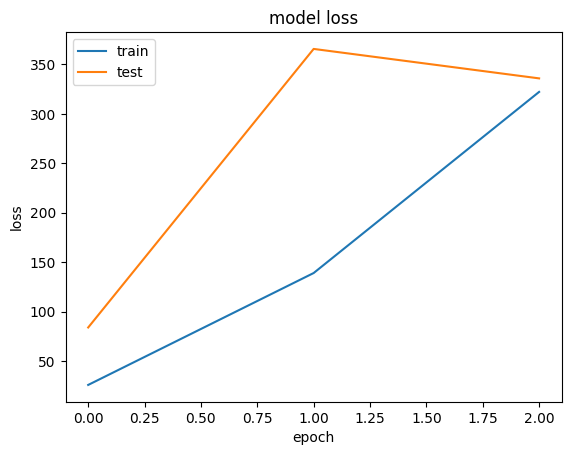

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

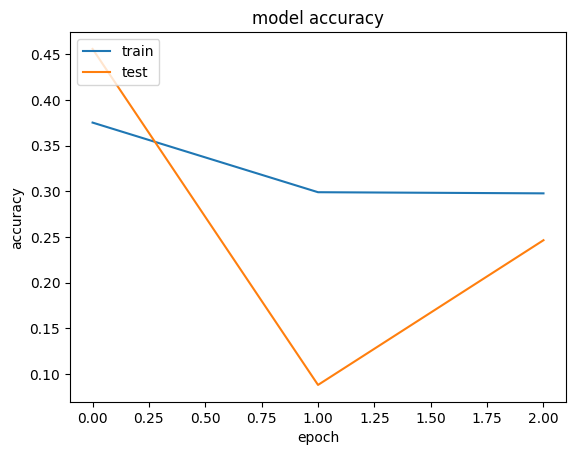

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])

plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

KeyError: 'auc'

In [ ]:
test_generator = ChestImagesDataset(df_test, DATA_DIR, batch_size = BATCH_SIZE, transform = None, training = False, shuffle = False)

predictions = model.predict(test_generator)

In [ ]:
roc_auc_score(df_test[unique_labels].values, predictions)

In [ ]:
## Metrics

def get_roc_curve(labels, predicted_vals, real_vals):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = real_vals[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals


get_roc_curve(list(unique_labels), predictions, df_test[unique_labels].values)

In [ ]:
# Grad-CAM
class GradCAM:
  def __init__(self, model, classIdx, baseModel = None, layerName = None):
    # store the model, the class index used to measure the class
    # activation map, and the layer to be used when visualizing
    # the class activation map
    if baseModel:
      self.model = model.get_layer(baseModel)
    else:
      self.model = model
    self.classIdx = classIdx
    self.layerName = layerName
    # if the layer name is None, attempt to automatically find
    # the target output layer
    if self.layerName is None:
      self.layerName = self.find_target_layer()

  def find_target_layer(self):
    # attempt to find the final convolutional layer in the network
    # by looping over the layers of the network in reverse order
    for layer in reversed(self.model.layers):
        # check to see if the layer has a 4D output
        if len(layer.output_shape) == 4:
            return layer.name
    # otherwise, we could not find a 4D layer so the GradCAM
    # algorithm cannot be applied
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

  def compute_heatmap(self, image, eps=1e-8):
    # construct our gradient model by supplying (1) the inputs
    # to our pre-trained model, (2) the output of the (presumably)
    # final 4D layer in the network, and (3) the output of the
    # softmax activations from the model
    gradModel = keras.Model(
      inputs=[self.model.inputs],
      outputs=[self.model.get_layer(self.layerName).output,
        self.model.output])

    # record operations for automatic differentiation
    with tf.GradientTape() as tape:
      # cast the image tensor to a float-32 data type, pass the
      # image through the gradient model, and grab the loss
      # associated with the specific class index
      inputs = tf.cast(image, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, self.classIdx]
    # use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)

    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    # the convolution and guided gradients have a batch dimension
    # (which we don't need) so let's grab the volume itself and
    # discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]

    # compute the average of the gradient values, and using them
    # as weights, compute the ponderation of the filters with
    # respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

    # grab the spatial dimensions of the input image and resize
    # the output class activation map to match the input image
    # dimensions
    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    # normalize the heatmap such that all values lie in the range
    # [0, 1], scale the resulting values to the range [0, 255],
    # and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")
    # return the resulting heatmap to the calling function
    return heatmap

  def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_VIRIDIS):
    # apply the supplied color map to the heatmap and then
    # overlay the heatmap on the input image
    image = img_as_ubyte(image)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    # return a 2-tuple of the color mapped heatmap and the output,
    # overlaid image
    return (heatmap, output)


idx = 45
image = X_test[idx:(idx+1),:,:,:]
preds = model.predict(image)
i = np.argmax(preds[0])

cam = GradCAM(model, i, baseModel = "vit-b16")#, layerName = "mixed10")
heatmap = cam.compute_heatmap(image)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_VIRIDIS)
(heatmap, output) = cam.overlay_heatmap(heatmap, image[0,:,:,:], alpha = 0.3)
plt.imshow(output)

In [ ]:
gradcam_explain = np.zeros((3, 224, 224))

nimages, _, _, _ = X_test.shape
with tf.device("/gpu:1"):
  for n in range(nimages):
    image = X_test[n,:,:,:].reshape(1, 224, 224, 3)
    preds = model.predict(image)
    top_label = np.argmax(preds[0])

    cam = GradCAM(model, top_label, baseModel = "vit-b16")#, layerName = "mixed10")
    heatmap = cam.compute_heatmap(image)
    heatmap = heatmap / 255
    
    gradcam_explain[top_label,:,:] = np.add(gradcam_explain[top_label,:,:], heatmap)
    

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 20)
sns.heatmap(gradcam_explain[0,:,:], cmap = "YlOrRd", xticklabels = False, yticklabels = False, cbar = False)